In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse

In [2]:
lx, ly = (1,1)
nx, ny = (1000, 1000)
deltax,deltay = (lx/nx , ly/ny)



In [3]:
x = np.linspace(0, lx, nx)

y = np.linspace(0, ly, ny)

a,b = np.meshgrid(x, y)

### Construction of the System Matrix

In [33]:
def newSystemMatrix_nx_ny(nx,ny,deltax,deltay):
    # returns a Systemmatrix, for constant boundary condition on the left and right side of the Domain
    I = sparse.lil_matrix( sparse.eye(nx*ny))
    # Main diagonal
    A = I * (-2/deltax**2 - 2 / deltay**2)
    # West / East diagonal
    A[range(1,nx*ny),range(0,nx*ny-1)]=1 / deltax**2
    A[range(0,ny*nx-1),range(1,nx*ny)]=1 / deltax**2
    # North / South diagonal
    A[range(nx,nx*ny),range(0,nx*ny-nx)]=1 / deltay**2
    A[range(0,ny*nx-nx),range(nx,nx*ny)]=1 / deltay**2
    
    # take Boundary Conditions into account
    # Dirichlet
    A[0,:] = 0; #Left
    A[-1,:] = 0; #Right
    for i in range(0,nx):
        #First cell of each row
        A[i*nx,:] = 0
        A[i*nx,i*nx] = 1
        #Last cell of each row
        A[i*nx+nx-1,:] = 0
        A[i*nx+nx-1,i*nx+nx-1] = 1
    #Neumann
    #A[range(nx,nx*2),range(0,nx)]*=2 #Bottom 
    A[range(0,nx),range(nx,nx*2)]*=2 #test 
    #A[range(nx*ny - 2*nx,nx*ny - nx),range(nx*ny - nx,nx*ny)]*=2 #Top
    A[range(nx*ny - nx,nx*ny),range(nx*ny - 2*nx,nx*ny - nx)]*=2 #Test
    return A

In [5]:
A = newSystemMatrix_nx_ny(nx,ny,deltax,deltay)

### Initial State

In [34]:
def newPinit(nx,ny,Pbcr,Pbcl):
    P_init = np.zeros(nx*ny)
    for i in range(0,nx):
        P_init[i*nx] = Pbcr #Left side
        P_init[i*nx+nx-1] = Pbcl #Right side
    return P_init

In [7]:
P_init = newPinit(nx,ny,20,15)

### Transport coefficients

In [8]:
#height of the channel
h= 0.0002 #m
rho = 1.35 # kg/m-3
mu =  17.5e-6 #kg m-1 s-1
k = h**2/12

### Solving the Pressure Field

In [35]:
def solveP(nx,ny,A,P_init):
    A_stat = A
    A_sparse = sparse.csr_matrix(A_stat)
    P = sparse.linalg.spsolve(A_sparse,P_init)
    P_matrix = P.reshape((nx,ny))
    return P_matrix
    

In [10]:
P_matrix = solveP(nx,ny,A,P_init)

### Velocity field and averaging

In [36]:
def averageV(P_matrix,deltax,nx,ny,mu,k):
    deltaPx, deltaPy = np.gradient(P_matrix,deltax) 
    v = np.sqrt(deltaPx**2+deltaPy**2) / mu * k
    return np.average(v[1:nx-1,1:ny-1])

In [12]:
v_avg = averageV(P_matrix,deltax,nx,ny,mu,k)

### Comparision to Analytical Solution

In [42]:
v_ana = h**2 / 12 / mu * (P_init[0] - P_init[-1]) / lx
print(v_ana,v_avg)

NameError: name 'P_init' is not defined

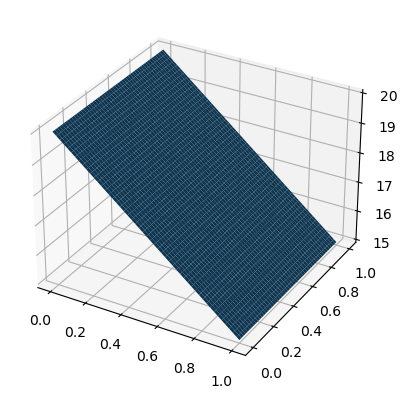

In [14]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(a[:nx,:nx],b[:nx,:nx],P_matrix[:nx,:nx])

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse

## Convergence study

In [43]:
def cvgStudy(gridsizes,lx,ly,Pbcr,Pbcl,h,mu):
    for tupel in gridsizes:
        nx = tupel[0]
        ny = tupel[1]
        print(nx,ny)
        deltax,deltay = (lx/nx , ly/ny)
        A = newSystemMatrix_nx_ny(nx,ny,deltax,deltay)
        P_init=newPinit(nx,ny,Pbcr,Pbcl)
        P_matrix = solveP(nx,ny,A,P_init)
        v_avg = averageV(P_matrix,deltax,nx,ny,mu,k)
        plt.scatter(tupel[0],v_avg)
    v_ana = h**2 / 12 / mu * (P_init[0] - P_init[-1]) / lx
    plt.plot([0,gridsizes[-1][0]],[v_ana,v_ana])
    plt.xlabel("Number of cells per direction $nx,ny$")
    plt.ylabel("Average velocity in the channel $v_avg$ [m/s]")

In [44]:
#transportcoefficients
#height of the channel
h= 0.0002 #m
rho = 1.35 # kg/m-3
mu =  17.5e-6 #kg m-1 s-1
k = h**2/12
#Boundary conditions
Pbcr = 20 #Pa
Pbcl = 15 #Pa
#Tested sizes
lx=1
ly=1
gridsizes = [(100,100),(200,200),(500,500),(1000,1000)]

100 100
200 200
500 500
1000 1000


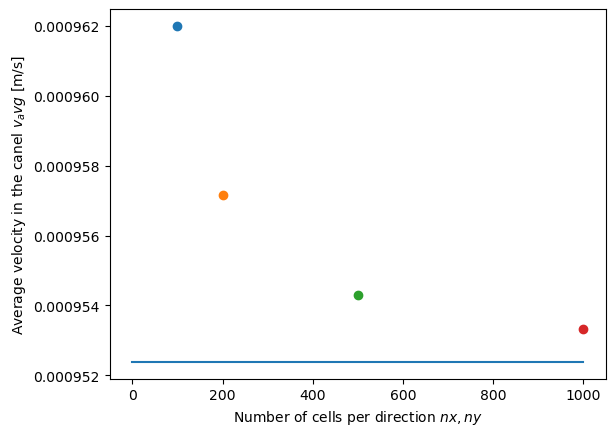

In [45]:
cvgStudy(gridsizes,lx,ly,Pbcr,Pbcl,h,mu)